In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
#import theano as T
#import theano.tensor as tt
import seaborn as sns
import matplotlib as mp
import numpy.random as npr
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
import mpl_toolkits as mpl
import datetime as dt
from scipy.stats.kde import gaussian_kde
import matplotlib.path as mpath
import scipy as sp
from theano import shared
import sqlite3
import cmocean as co
#import joypy as jp
from matplotlib.patches import Rectangle
import palettable
import os
import pdb
#mp.pyplot.style.use('ggplot')
mp.pyplot.style.use('seaborn-darkgrid')


In [2]:
os.environ['PROJ_LIB'] = '/anaconda3/share/proj'

In [3]:
(1-0.026*(50/34))**90

0.029936098947162537

In [4]:
#from mpl_toolkits.basemap import Basemap

In [5]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])
npm = np.median

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def SMA(array):
    return npr.choice(array)

def SMX(matrix,indx):
    return npr.choice(matrix[matrix.columns[indx]].values)

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1,lui=5,uli=95):
    if np.percentile(vector,lui)<0 and 0<np.percentile(vector,uli):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

# Summary functions
def CB(new,vec,obs,base,indx,valx=0):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)[vec[indx]!=valx]*100

def CBx(new,obs,base):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)*100

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def abline(intercept,slope,col='black',alpha=1):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='black',alpha=alpha)

## Import data

In [6]:
# Import FP data
fpdata = pd.read_csv('FinPrint_Set_Data.csv')
# Import location-scale data
ldata = pd.read_csv('Location_Covariates.csv')
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'

xdata.location_name[xdata.location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
xdata.location_name[xdata.location_name=='British West Indies '] = 'Montserrat'
ldata.FP_location_name[ldata.FP_location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
ldata.FP_location_name[ldata.FP_location_name=='British West Indies '] = 'Montserrat' 

xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (23,26,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-6-cfee8e709d79>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
<ipython-input-6-cfee8e709d79>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
<ipython-input-6-cfee8e709d79>:15: SettingWithC

In [7]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [8]:
xdata.loc[xdata['set_id'].isin(np.array([6783,29122,33986,20819,34989,22974,10335,24488,8863,7255]))].to_csv('highlev.csv')

In [9]:
# Remove high leverage observations
xdata = xdata[xdata.set_id!=6783]
xdata = xdata[xdata.set_id!=29122]
xdata = xdata[xdata.set_id!=33986]
xdata = xdata[xdata.set_id!=20819]
xdata = xdata[xdata.set_id!=34989]
xdata = xdata[xdata.set_id!=22974]
xdata = xdata[xdata.set_id!=10335]
xdata = xdata[xdata.set_id!=24488]
xdata = xdata[xdata.set_id!=8863]
xdata = xdata[xdata.set_id!=7255]
xdata = xdata[xdata.set_id!=32874]

In [10]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

RegionL,Irl = subindexall(xdata.region_name.values,xdata.location_name.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [11]:
xdata.columns


Index(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code', 'set_id',
       'set_code', 'set_date', 'set_latitude', 'set_longitude', 'maxn',
       'functional_group', 'depth', 'drop_time', 'haul_time', 'bait',
       'bait_oiled', 'current_flow_estimated', 'current_flow_instrumented',
       'visibility', 'field_of_view', 'substrate_relief_sd',
       'substrate_relief_mean', 'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones', 'unconsolidated',
       'zoanthids', 'video_length_watched', 'video_filename', 'vide

In [12]:
np.mean(xdata.loc[Ils==LocationS.index('South Africa'),]['MaxN_shark'].values)

0.46794871794871795

In [13]:
xdata.loc[Ils==LocationS.index('Japan'),]['MaxN_shark'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [14]:
len(Ilr)

371

In [15]:
max(xdata.mpa_area.values[np.isnan(xdata.mpa_area.values)==False])

1976000.0

In [16]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

# Coastline length
CLN = stdize(ldata.CoastLength.values[lkey])

# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Month
MON = np.array([dt.datetime.strptime(x,'%Y-%m-%d').month for x in xdata.set_date.values])
xdata['Month'] = MON

# Hemisphere
HEM = (xdata.set_latitude.values<0)*1

# Seasonality
iSEA = [['Winter','Winter','Shoulder','Shoulder','Summer','Summer','Summer','Summer','Shoulder','Shoulder','Winter','Winter'],['Summer','Summer','Shoulder','Shoulder','Winter','Winter','Winter','Winter','Shoulder','Shoulder','Summer','Summer']]
SEA,Ic = indexall(np.array([iSEA[h][m-1] for h,m in zip(HEM,MON)]))
nsea = len(SEA)
xdata['Season'] = np.array(SEA)[Ic]

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

<ipython-input-16-4760777d59d8>:90: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  xdata.Sharkgear = xdata.Shark_gears.fillna('None')


In [17]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [18]:
np.mean(OCC)

0.3771183646554566

In [19]:
np.array([sum(OCC[Ir==r])>0 for r in np.unique(Ir)]).sum()/nreefs

0.8059299191374663

In [20]:
Ir

array([  0,   1,   1, ..., 370, 370, 370])

In [21]:
np.array([MaxN[Ir==r] for r in np.unique(Ir)])

array([array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0]),
       array([0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([2, 4, 2, 0, 0, 1, 0, 3, 2, 0, 2, 2, 2, 1, 3, 3, 1, 8, 6, 0, 2, 0,
       0, 1, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 1, 0, 2, 1, 3, 1, 2,
       4, 3, 1, 5, 1, 0, 2, 9, 2, 2, 0, 2, 1, 1, 1, 1, 1, 3, 3, 2, 5, 2,
       4, 0, 2, 1, 2, 4, 1, 0, 1, 3, 3, 3, 2, 3, 3, 2, 2, 0, 0, 0, 1, 1,
       0, 1, 2, 1, 0, 1, 0]),
       array([0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 3, 1, 1, 1, 0, 0, 2, 2, 3,
       0, 1, 2, 1, 2, 1, 1, 1, 0, 5, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0,
       2]),
       array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 1, 2, 2, 1, 3, 0, 0, 3, 1, 0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 1,
       0, 2, 5, 3, 1, 0, 0, 0]),
   

In [22]:
xdata.head()

,region_name,region_id,location_name,location_code,location_id,site_name,site_code,site_id,reef_name,reef_type,...,drop_hr,LatLon,Grav_NC,Grav_Total,Grav_Cities,Grav_NP,MaxN_shark,Month,Season,proportional_difference
0,Western Atlantic,1,USA-Western Atlantic,US-A,12,Florida,F,46,Upper Keys 1,slope,...,14,25.000496_-80.38673,0.927931,275,8.072851,0.933005,1,5,Summer,0.049090
9,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.04949_-74.53631,0.353483,3,1.448604,0.002934,0,5,Summer,0.224044
18,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.05842_-74.53868,0.353483,3,1.448604,0.002934,0,5,Summer,0.224093
27,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.08407_-74.53813000000001,0.353483,3,1.448604,0.002934,0,5,Summer,0.221781
36,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.10889_-74.53123000000001,0.392073,4,1.197989,0.010237,0,5,Summer,0.215085


In [23]:
tmp = xdata.groupby(['location_name', 'Month'])['reef_id'].agg(['count']).reset_index(level=['Month']).pivot(columns='Month', values='count').fillna(0).astype(int)
tmp.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
location_name,,,,,,,,,,,,
American Samoa,0,0,0,103,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,79
Australia IOT,128,0,99,99,255,169,0,0,148,0,0,0
Australia-Indian Ocean,0,0,0,53,217,0,0,430,696,458,0,75
Australia-Pacific,150,12,0,129,65,1,0,0,0,0,219,0


In [24]:
# National summaries of data collection
xdata.groupby('location_name')['set_date'].min().values

array(['2016-04-06', '2016-12-05', '2013-05-14', '2010-10-01',
       '2013-04-22', '2015-01-06', '2017-06-23', '2009-06-21',
       '2018-06-24', '2017-07-21', '2016-11-26', '2016-09-23',
       '2017-09-20', '2017-01-17', '2016-06-24', '2017-07-14',
       '2016-02-24', '2012-01-01', '2017-03-04', '2009-05-11',
       '2016-11-11', '2016-04-08', '2010-02-17', '2017-11-27',
       '2016-03-24', '2016-01-11', '2017-05-09', '2017-05-11',
       '2017-12-01', '2017-05-18', '2016-05-16', '2015-11-15',
       '2016-05-20', '2017-10-16', '2016-08-09', '2016-01-07',
       '2017-08-31', '2016-09-27', '2016-05-29', '2017-09-25',
       '2016-01-16', '2017-06-14', '2016-12-14', '2017-08-02',
       '2017-11-29', '2017-01-20', '2015-10-19', '2016-11-02',
       '2017-04-05', '2017-04-04', '2017-03-15', '2017-08-28',
       '2016-01-06', '2015-10-17', '2012-01-10', '2013-06-22',
       '2016-09-24', '2017-07-12'], dtype=object)

In [25]:
# National summaries of data collection
tmp['Start Date'] = xdata.groupby('location_name')['set_date'].min().values
tmp['End Date'] = xdata.groupby('location_name')['set_date'].min().values

In [26]:
# Export
tmp.to_csv('Sampling_summaries.csv')

## Import results

In [27]:
# Import model results
BTrez_SH_full = pd.read_csv('Sharks_ZINB_results_.csv')
BTrez_SH_count = pd.read_csv('Sharks_ZINB_full_count_results_.csv')
BTrez_SH_null = pd.read_csv('Sharks_ZINB_partial_null_results_.csv')

In [28]:
BTrez_SH_full.shape

(20000, 173)

In [29]:
# Import LOO results
LOO = pd.read_csv("ModelCompLoo_final.csv")

In [30]:
LOO

,Unnamed: 0,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
0,ZINB_full,0,27583.702069,301.874593,0.000000,7.706269e-01,283.928392,0.000000,False,deviance
1,ZINB_full_count,1,27588.331872,304.962335,4.629803,1.611807e-01,247.223487,3.780513,False,deviance
2,ZINB_partial_null,2,27594.670910,310.045375,10.968841,6.819247e-02,247.128875,6.619924,False,deviance
3,non_ZI_full,3,27738.835565,288.423006,155.133496,2.983906e-19,247.515099,29.428213,False,deviance
4,non_ZI_partial_null,4,27739.616104,289.643251,155.914035,4.937138e-20,247.446635,29.720998,False,deviance
5,Null,5,37081.397375,2.479854,9497.695306,0.000000e+00,247.187333,160.883542,False,deviance


In [31]:
# Extract weights
loo_f = LOO.weight[LOO['Unnamed: 0']=='ZINB_full'].values[0]
loo_c = LOO.weight[LOO['Unnamed: 0']=='ZINB_full_count'].values[0]
loo_n = LOO.weight[LOO['Unnamed: 0']=='ZINB_partial_null'].values[0]

In [32]:
BTrez_ = [BTrez_SH_full]
BTlabs = ['Sharks']

nfg = len(BTrez_)

In [33]:
np.array(LocationR)

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia-Red Sea',
       'Guam', 'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype='<U30')

In [34]:
beta_Region_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]*loo_f
beta_Region_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]*loo_c
beta_Region_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]*loo_n

In [35]:
SEA

['Summer', 'Winter', 'Shoulder']

In [36]:
params =[]

# Global rate
beta_global = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_n

# Regional rates
beta_Region_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]*loo_f
beta_Region_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]*loo_c
beta_Region_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]*loo_n
beta_Region = beta_Region_f+beta_Region_c+beta_Region_n
beta_Region.columns = [x[14:] for x in beta_Region.columns]

# Grab reef type
beta_Reef_type_f = BTrez_SH_full[grep('Reef_type',BTrez_SH_full.columns.values)]*loo_f
beta_Reef_type_c = BTrez_SH_count[grep('Reef_type',BTrez_SH_count.columns.values)]*loo_c
beta_Reef_type_n = BTrez_SH_null[grep('Reef_type',BTrez_SH_null.columns.values)]*loo_n
beta_Reef_type = beta_Reef_type_f+beta_Reef_type_c+beta_Reef_type_n
beta_Reef_type.columns = [x[10:] for x in beta_Reef_type.columns]

# Grab bait type
beta_Bait_type_f = BTrez_SH_full[grep('Bait_type',BTrez_SH_full.columns.values)]*loo_f
beta_Bait_type_c = BTrez_SH_count[grep('Bait_type',BTrez_SH_count.columns.values)]*loo_c
beta_Bait_type_n = BTrez_SH_null[grep('Bait_type',BTrez_SH_null.columns.values)]*loo_n
beta_Bait_type = beta_Bait_type_f+beta_Bait_type_c+beta_Bait_type_n

# Seasonality
beta_Seasonality_f = BTrez_SH_full[grep('Seasonality',BTrez_SH_full.columns.values)]*loo_f
beta_Seasonality_c = BTrez_SH_count[grep('Seasonality',BTrez_SH_count.columns.values)]*loo_c
beta_Seasonality_n = BTrez_SH_null[grep('Seasonality',BTrez_SH_null.columns.values)]*loo_n
beta_Seasonality = beta_Seasonality_f+beta_Seasonality_c+beta_Seasonality_n
beta_Seasonality.columns = SEA[1:]

# National scale
#beta_HDI = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values*loo_c
#beta_VOICE = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('VOICE')]].values*loo_c
#beta_POP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c
beta_HDI = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values*loo_f
beta_VOICE = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values*loo_f
beta_POP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values*loo_f


beta_HDI_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values*loo_c
beta_VOICE_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c
beta_POP_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c

beta_Sanctuary = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Sanctuary')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Sanctuary')]].values*loo_c
beta_CoastL = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('CoastLength')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('CoastLength')]].values*loo_c

# Reef scale
beta_clo = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Closed')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Closed')]].values*loo_c
beta_HIC = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('High_compliance')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('High_compliance')]].values*loo_c
beta_Remote = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Remote')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Remote')]].values*loo_c
beta_MPAsize = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('MPA_size')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('MPA_size')]].values*loo_c


beta_Gill = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gillnet_longline')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gillnet_longline')]].values*loo_c

beta_Drumline = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Drumline')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Drumline')]].values*loo_c
beta_HookLine = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HookLine')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HookLine')]].values*loo_c

beta_Catch = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Catch')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Catch')]].values*loo_c
beta_Temporal = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Temporal')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Temporal')]].values*loo_c
beta_Spp = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Species')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Species')]].values*loo_c

beta_Gravity_NP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NP')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NP')]].values*loo_c
beta_Gravity_NC = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NC')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NC')]].values*loo_c

# Set scale
beta_vis = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Visibililty')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values*loo_n
beta_hc = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Hard_coral')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values*loo_n
beta_rug = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Rugosity')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values*loo_n
beta_Depth = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Depth')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values*loo_n
beta_Time = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('TimeODay')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values*loo_n


params += [ [beta_HDI, beta_VOICE, beta_POP, beta_Sanctuary, beta_CoastL, beta_clo, beta_MPAsize, beta_HIC, beta_Remote, beta_Gill, beta_Drumline,beta_HookLine, beta_Catch, beta_Temporal, beta_Spp, beta_Gravity_NP, beta_Gravity_NC, beta_vis, beta_hc, beta_rug, beta_Depth, beta_Seasonality['Winter'], beta_Seasonality['Shoulder']] + [beta_Reef_type.iloc[:, i].values for i in range(len(beta_Reef_type.columns))]+[beta_Region.iloc[:, i].values-beta_global for i in range(len(beta_Region.columns))]]

    
parmlabels = ['HDI', 'Voice & accountability','Population size', 'Shark sanctuary', 'Coast length', 'Closed', 'MPA size', 'High compliance', 'Remote', 'Gillnet/longline', 'Drumline', 'Hook and line', 'Catch limit', 'Temporal limit', 'Species restriction', 'Gravity NP','Gravity NC', 'Visibility', 'Hard coral', 'Rugosity', 'Depth', 'Winter', 'Shoulder']+list(beta_Reef_type.columns)+['Western Atlantic', 'Central Pacific', 'Indian Ocean', 'Western Pacific']

nparms = len(params[0])
nparms, len(parmlabels), 

(31, 31)

In [37]:
np.quantile(BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values,0.5,axis=0)

0.09647479153159569

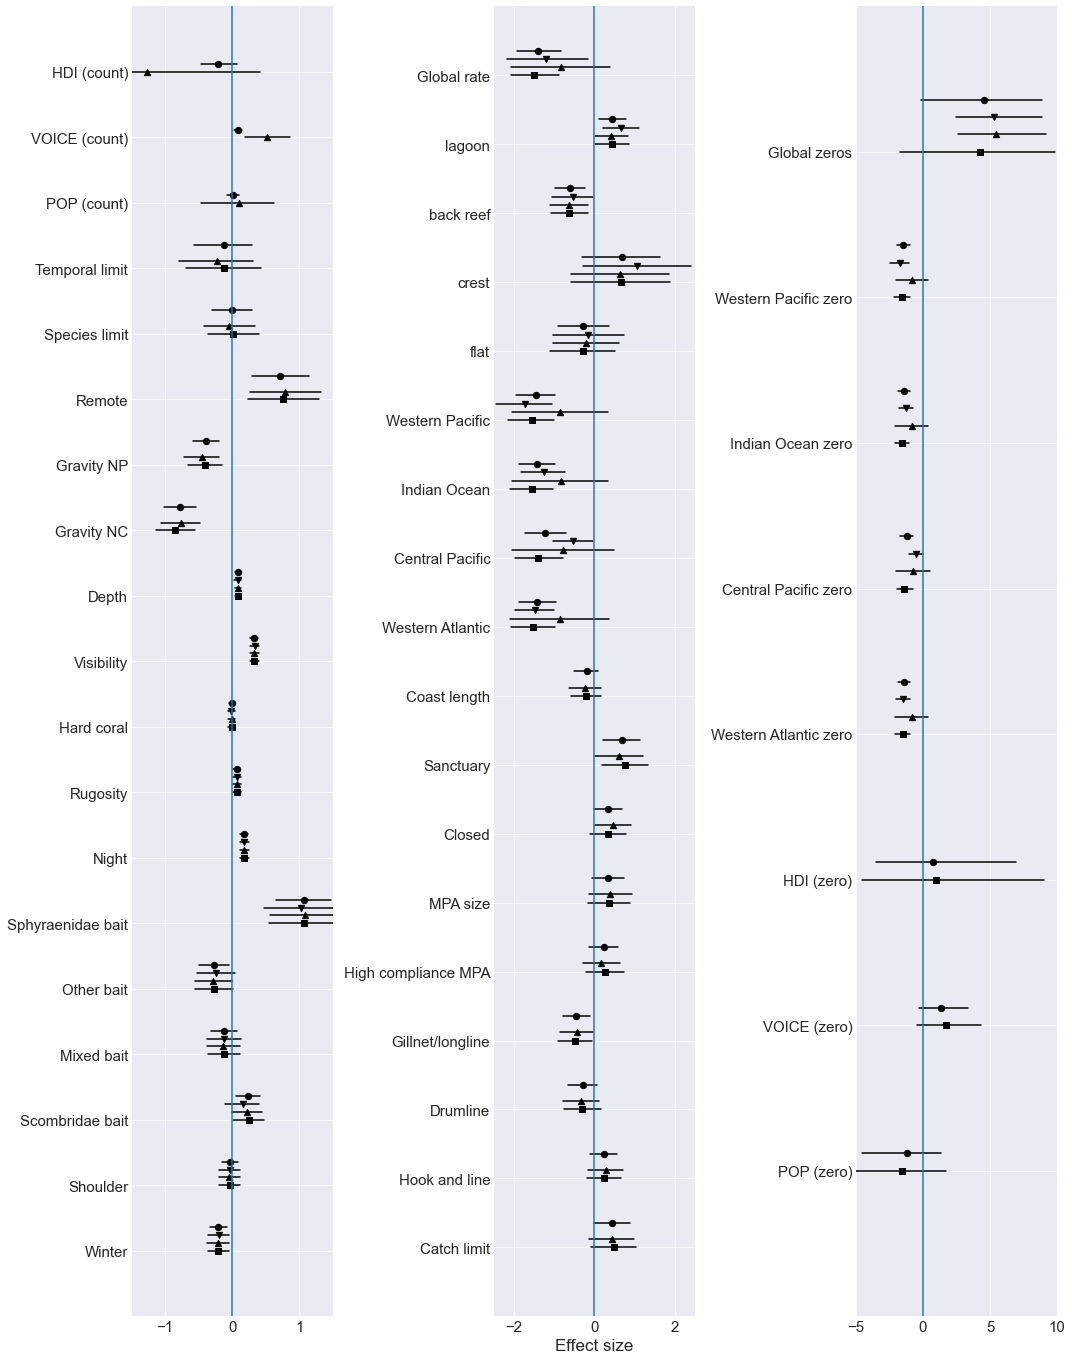

In [38]:
# Set up variables
varlist1 = ["Global_rate","Regional_rate","CoastLength","Sanctuary","Reef_type","Visibililty","Hard_coral","Rugosity"
            ,"Depth","Bait_type","Seasonality"][::-1]
varlist2 = ["Gravity_NP","Gravity_NC","Catch","Temporal","Species","Closed","High_compliance","MPA_size","Remote",
            "Gillnet_longline", "Drumline", "HookLine"][::-1]
varlist2b = ["HDI","VOICE","POP"]
varlist3 = ["Global_zeros","Regional_zeros","HDI","VOICE","POP"][::-1]


# Set up plot
fig = plt.figure(figsize=(15, 19))
gs = mp.gridspec.GridSpec(1, 3)
ax = np.array([fig.add_subplot(gs[i,j]) for i in range(1) for j in range(3)]).reshape(1,3)[0]
# Offset
oset = 0.12
# Point size
sx = 40

# Variable list 1
ax[0].plot(1,1,marker="")
ax[0].set_ylim(0,20)
ax[0].set_xlim(-1.5,1.5)

# Axis labels
alab = []

# Seasonality
tmp_f = BTrez_SH_full[grep('Seasonality',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Seasonality',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Seasonality',BTrez_SH_null.columns.values)]
ax[0].scatter(np.median(tmp_f,axis=0),[1,2],s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c,axis=0),[1+oset,2+oset],s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n,axis=0),[1+oset*2,2+oset*2],s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Seasonality,axis=0),[1+oset*3,2+oset*3],s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[1,1],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[2,2],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[1+oset,1+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[2+oset,2+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[1+oset*2,1+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[2+oset*2,2+oset*2],c='black')
ax[0].plot(np.quantile(beta_Seasonality,(0.05,0.95),axis=0).T[0],[1+oset*3,1+oset*3],c='black')
ax[0].plot(np.quantile(beta_Seasonality,(0.05,0.95),axis=0).T[1],[2+oset*3,2+oset*3],c='black')
alab += SEA[1:]

# Bait type
tmp_f = BTrez_SH_full[grep('Bait_type',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Bait_type',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Bait_type',BTrez_SH_null.columns.values)]
ax[0].scatter(np.median(tmp_f,axis=0),[3,4,5,6],s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c,axis=0),[3+oset,4+oset,5+oset,6+oset],s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n,axis=0),[3+oset*2,4+oset*2,5+oset*2,6+oset*2],s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Bait_type,axis=0),[3+oset*3,4+oset*3,5+oset*3,6+oset*3],s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[3,3],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[4,4],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[5,5],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[6,6],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[3+oset,3+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[4+oset,4+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[5+oset,5+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[6+oset,6+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[3+oset*2,3+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[4+oset*2,4+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[5+oset*2,5+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[6+oset*2,6+oset*2],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[0],[3+oset*3,3+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[1],[4+oset*3,4+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[2],[5+oset*3,5+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[3],[6+oset*3,6+oset*3],c='black')
alab += [b+' bait' for b in BAIT[1:]]

# Time of day
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('TimeODay')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('TimeODay')]].values
beta_TimeODay = tmp_f*loo_f+tmp_c*loo_c+tmp_n*loo_n
ax[0].scatter(np.median(tmp_f),7,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),7+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),7+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_TimeODay),7+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[7,7],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[7+oset,7+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[7+oset*2,7+oset*2],c='black')
ax[0].plot(np.quantile(beta_TimeODay,(0.05,0.95)),[7+oset*3,7+oset*3],c='black')
alab += ['Night']

# Rugosity
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Rugosity')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Rugosity')]].values
ax[0].scatter(np.median(tmp_f),8,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),8+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),8+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_rug),8+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[8,8],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[8+oset,8+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[8+oset*2,8+oset*2],c='black')
ax[0].plot(np.quantile(beta_rug,(0.05,0.95)),[8+oset*3,8+oset*3],c='black')
alab += ['Rugosity']

# Hard coral
i=9
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Hard_coral')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Hard_coral')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_hc),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_hc,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Hard coral']

# Visibility
i=10
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Visibililty')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Visibililty')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_vis),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_vis,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Visibility']

# Depth
i=11
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Depth')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Depth')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Depth),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_Depth,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Depth']

# Gravity_NC
i=12
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NC')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NC')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Gravity_NC),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Gravity_NC,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gravity NC']

# Gravity_NP
i=13
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NP')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NP')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Gravity_NP),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Gravity_NP,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gravity NP']

# Remote
i=14
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Remote')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Remote')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Remote),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Remote,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Remote']

# Species
i=15
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Species')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Species')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Spp),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Spp,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Species limit']


# Temporal
i=16
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Temporal')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Temporal')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Temporal),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Temporal,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Temporal limit']

# Population
i=17
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['POP (count)']


# Voice
i=18
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('VOICE')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['VOICE (count)']

# HDI
i=19
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['HDI (count)']


ax[0].set_yticks(np.arange(len(alab))+1)
ax[0].set_yticklabels(alab,fontsize=15)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# Variable list 1
ax[1].plot(1,1,marker="")
ax[1].set_ylim(0,19)
ax[1].set_xlim(-2.5,2.5)

# Axis labels
alab = []

# Catch
i=1
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Catch')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Catch')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Catch),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Catch,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Catch limit']

# HookLine
i=2
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HookLine')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HookLine')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_HookLine),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_HookLine,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Hook and line']

# Drumline
i=3
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Drumline')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Drumline')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Drumline),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Drumline,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Drumline']

# Drumline
i=4
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gillnet_longline')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gillnet_longline')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Gill),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Gill,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gillnet/longline']


# High_compliance
i=5
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('High_compliance')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('High_compliance')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_HIC),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_HIC,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['High compliance MPA']


# MPA_size
i=6
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('MPA_size')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('MPA_size')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_MPAsize),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_MPAsize,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['MPA size']

# Closed
i=7
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Closed')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Closed')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_clo),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_clo,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Closed']

# Sanctuary
i=8
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Sanctuary')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Sanctuary')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Sanctuary),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Sanctuary,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Sanctuary']


# CoastLength
i=9
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('CoastLength')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('CoastLength')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_CoastL),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_CoastL,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Coast length']


# Regional rate
tmp_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
ax[1].scatter(np.median(tmp_f,axis=0),[10,11,12,13],s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c,axis=0),[10+oset,11+oset,12+oset,13+oset],s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n,axis=0),[10+oset*2,11+oset*2,12+oset*2,13+oset*2],s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_Region,axis=0),[10+oset*3,11+oset*3,12+oset*3,13+oset*3],s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[10,10],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[11,11],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[12,12],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[13,13],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[10+oset,10+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[11+oset,11+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[12+oset,12+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[13+oset,13+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[10+oset*2,10+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[11+oset*2,11+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[12+oset*2,12+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[13+oset*2,13+oset*2],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[0],[10+oset*3,10+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[1],[11+oset*3,11+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[2],[12+oset*3,12+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[3],[13+oset*3,13+oset*3],c='black')
alab += Region


# Reef type
tmp_f = BTrez_SH_full[grep('Reef_type',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Reef_type',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Reef_type',BTrez_SH_null.columns.values)]
ax[1].scatter(np.median(tmp_f,axis=0),[14,15,16,17],s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c,axis=0),[14+oset,15+oset,16+oset,17+oset],s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n,axis=0),[14+oset*2,15+oset*2,16+oset*2,17+oset*2],s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_Reef_type,axis=0),[14+oset*3,15+oset*3,16+oset*3,17+oset*3],s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[14,14],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[15,15],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[16,16],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[17,17],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[14+oset,14+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[15+oset,15+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[16+oset,16+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[17+oset,17+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[14+oset*2,14+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[15+oset*2,15+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[16+oset*2,16+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[17+oset*2,17+oset*2],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[0],[14+oset*3,14+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[1],[15+oset*3,15+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[2],[16+oset*3,16+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[3],[17+oset*3,17+oset*3],c='black')
alab += RTY[1:]


# Global rate
i=18
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Global_rate')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_global),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[1].plot(np.quantile(beta_global,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Global rate']



ax[1].set_yticks(np.arange(len(alab))+1)
ax[1].set_yticklabels(alab,fontsize=15)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# Variable list 1
ax[2].plot(1,1,marker="")
ax[2].set_ylim(0,9)
ax[2].set_xlim(-5,10)

# Axis labels
alab = []


# Population
i=1
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_POP),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_POP,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['POP (zero)']


# Voice
i=2
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_VOICE),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_VOICE,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['VOICE (zero)']

# HDI
i=3
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_HDI),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_HDI,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['HDI (zero)']


# Regional rate
tmp_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
ax[2].scatter(np.median(tmp_f,axis=0),[4,5,6,7],s=sx,c='black',marker='s')
ax[2].scatter(np.median(tmp_c,axis=0),[4+oset,5+oset,6+oset,7+oset],s=sx,c='black',marker='^')
ax[2].scatter(np.median(tmp_n,axis=0),[4+oset*2,5+oset*2,6+oset*2,7+oset*2],s=sx,c='black',marker='v')
ax[2].scatter(np.median(beta_Region,axis=0),[4+oset*3,5+oset*3,6+oset*3,7+oset*3],s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[4,4],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[5,5],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[6,6],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[7,7],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[4+oset,4+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[5+oset,5+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[6+oset,6+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[7+oset,7+oset],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[4+oset*2,4+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[5+oset*2,5+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[6+oset*2,6+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[7+oset*2,7+oset*2],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[0],[4+oset*3,4+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[1],[5+oset*3,5+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[2],[6+oset*3,6+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[3],[7+oset*3,7+oset*3],c='black')
alab += [r+' zero' for r in Region]


# Global rate
i=8
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_zeros')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Global_zeros')]].values
beta_global_zeros = tmp_f*loo_f+tmp_c*loo_c+tmp_n*loo_n
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[2].scatter(np.median(beta_global_zeros),i+oset*3,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[2].plot(np.quantile(beta_global_zeros,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Global zeros']


ax[2].set_yticks(np.arange(len(alab))+1)
ax[2].set_yticklabels(alab,fontsize=15)


ax[0].axvline(x=0)
ax[1].axvline(x=0)
ax[2].axvline(x=0)

ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[2].tick_params(labelsize=15)

#ax[0].text(-2,17,"a",fontsize=20, fontweight='bold')
#ax[1].text(-3.5,19,"b",fontsize=20, fontweight='bold')
#ax[2].text(-7,9,"c",fontsize=20, fontweight='bold')

ax[1].set_xlabel('Effect size',fontsize=17)

plt.tight_layout()
plt.savefig('ED_Figure_2.pdf');

In [39]:
np.median(tmp_f)

4.251520678441041

In [40]:
np.quantile(tmp_f,(0.05,0.95),axis=0)[0]

-1.7460548775151903

In [41]:
np.quantile(BTrez_SH_full.alpha.values, (.5,0.05,.95))

array([6.64100932, 5.79329259, 7.73185966])

In [42]:
np.quantile(beta_HDI, (.5,0.05,.95))

array([ 0.77230329, -3.532652  ,  6.93255233])

In [43]:
np.quantile(beta_Seasonality.Winter, (.5,0.05,.95))

array([-0.20579332, -0.33196081, -0.0801237 ])

In [44]:
np.quantile(beta_Seasonality.Shoulder, (.5,0.05,.95))

array([-0.03805662, -0.15937755,  0.08177681])

In [45]:
np.quantile(beta_vis, (.5,0.05,.95))

array([0.32922159, 0.27125855, 0.38582939])

In [46]:
np.quantile(beta_hc, (.5,0.05,.95))

array([-0.00916413, -0.05168873,  0.03260526])

In [47]:
np.quantile(beta_rug, (.5,0.05,.95))

array([0.06921172, 0.01677374, 0.12176136])

In [48]:
np.quantile(beta_Depth, (.5,0.05,.95))

array([0.08379726, 0.04296387, 0.12531662])

In [49]:
BAIT

['Clupeidae', 'Scombridae', 'Mixed', 'Other', 'Sphyraenidae']

In [50]:
[np.quantile(beta_Bait_type[b], (.5,0.05,.95)) for b in beta_Bait_type.columns]

[array([0.23372913, 0.05007312, 0.41768479]),
 array([-0.12267891, -0.31528565,  0.07201671]),
 array([-0.27287048, -0.48813896, -0.05090302]),
 array([1.07139241, 0.65319053, 1.46827268])]

## Expected benefits

In [51]:
# Gillnet/longline ban
1-np.percentile(np.exp(beta_global)/np.exp(beta_global-beta_Gill),(5,50,95))

array([0.54034088, 0.35984749, 0.10969006])

In [52]:
# Catch limit
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_Catch),(5,50,95))

array([ 0.58433083,  0.35966982, -0.00310277])

In [53]:
# Average closure
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_clo),(5,50,95))

array([ 0.49694546,  0.28103383, -0.00889556])

In [54]:
# Big closure
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_clo+beta_MPAsize),(5,50,95))

array([0.70800599, 0.48566947, 0.11641382])

In [55]:
# Shark Sanctuary
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_Sanctuary),(5,50,95))

array([0.67858796, 0.49549366, 0.20124448])

In [56]:
# Drumline ban
1-np.percentile(np.exp(beta_global)/np.exp(beta_global-beta_Drumline),(5,50,95))

array([ 0.47928301,  0.25091059, -0.0789777 ])

In [57]:
# Hook and line
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_HookLine),(5,50,95))

array([ 0.43431655,  0.20369099, -0.12292138])

## Parameter plots

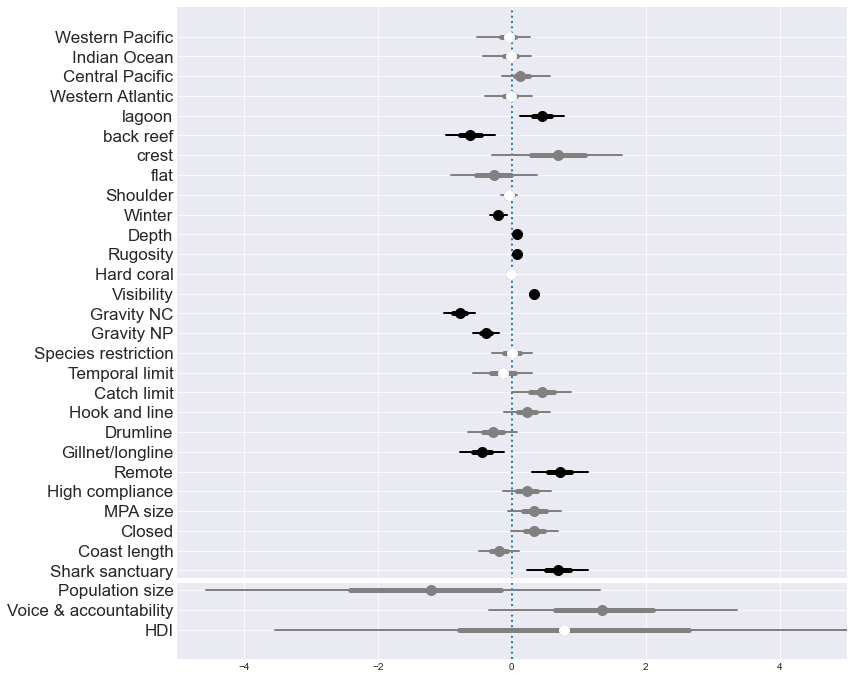

In [58]:
fig = plt.figure(figsize=(12, 12))
gs = mp.gridspec.GridSpec(1, nfg)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 5

for i in range(nfg):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,params[i][j],j,csize=20,lwd50=5,lwd95=2) for j in range(nparms)]
    if i==0:
        ax.set_yticks(range(nparms))
        ax.set_yticklabels(parmlabels,fontsize=17)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    #Aax.set_title(BTlabs[i],fontsize=17)

ax.axhline(2.5,c='white',linewidth=5)



plt.savefig('ED_Figure_1.pdf')

In [59]:
paramz = [beta_HDI, beta_VOICE, beta_POP, beta_Gravity_NP, beta_Gravity_NC]
parmlabelz = ['HDI','Voice & accountability','Population size','Gravity (Nearest population)','Gravity (Nearest city)']
nparamz = len(paramz)

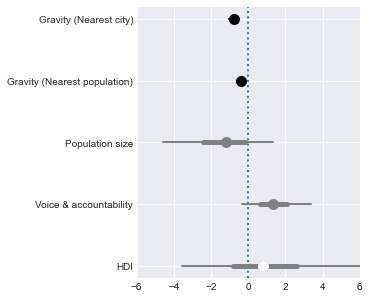

In [60]:
fig = plt.figure(figsize=(4, 5))
gs = mp.gridspec.GridSpec(1, nfg)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 6

for i in range(1):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,paramz[j],j,csize=20,lwd50=5,lwd95=2) for j in range(nparamz)]
    if i==0:
        ax.set_yticks(range(nparamz))
        ax.set_yticklabels(parmlabelz)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    
plt.savefig('Figure_1d.pdf', bbox_inches='tight')

In [61]:
beta_zero = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_zeros')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values*loo_n

In [62]:
pz = 1-np.mean(invlogit(beta_zero))
pz,pz*len(MaxN)

(0.09770720062329907, 1481.7296974523304)

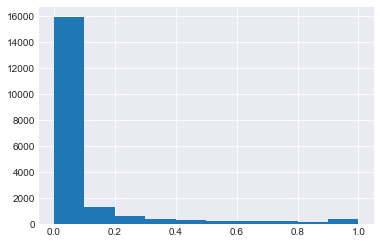

In [63]:
plt.hist(1-invlogit(beta_zero));

In [64]:
1.02e+04

10200.0

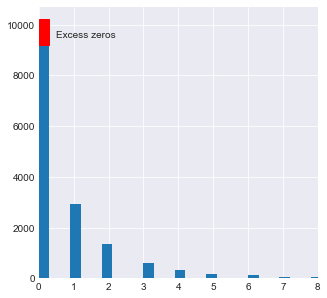

In [65]:
fig = plt.figure(figsize=(5,5))
plt.hist(xdata.MaxN_shark.values,bins=100)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0.01, 1.02e+04*(1-pz)), .27, 1.02e+04*pz, alpha=1, color='red'))
plt.text(0.5, 1.0e+04*(1-pz/2), 'Excess zeros')
plt.xlim(0,8)
plt.savefig('Figure_1b.pdf')

## Cohen's d calcs - Ringen et al.

In [66]:
varlist = ['Sanctuary','Gillnet_longline', 'Drumline', 'HookLine', 'Closed', 'MPA_size', 'High_compliance', 'Catch', 'Temporal', 'Species']
varnames = ['Shark sanctuary','Gillnet/longline', 'Drumline', 'Hook & Line', 'Closed area', 'MPA size', 'High compliance', 'Catch limit', 'Temporal limit', 'Species limit']
nvar = len(varlist)
BTrez = BTrez_SH_full[varlist]*loo_f+BTrez_SH_count[varlist]*loo_c
Cohens_d = BTrez_SH_full[varlist]*(np.sqrt(3)/np.pi)*loo_f+BTrez_SH_count[varlist]*(np.sqrt(3)/np.pi)*loo_c
Cohens_d.columns = varnames

In [67]:
Cohens_d.head()

,Shark sanctuary,Gillnet/longline,Drumline,Hook & Line,Closed area,MPA size,High compliance,Catch limit,Temporal limit,Species limit
0,0.418861,-0.265506,-0.146740,-0.029704,0.136080,0.272427,-0.015956,0.324450,-0.083351,0.075366
1,0.366369,-0.371641,0.023703,0.045578,0.101821,0.034210,0.299604,0.201966,0.006210,-0.001045
2,0.385028,-0.288856,-0.165756,0.235910,0.115470,0.024489,0.296026,0.400590,0.182105,-0.082682
3,0.360814,-0.265842,0.123419,0.018835,0.242317,0.247623,0.052878,0.185023,-0.149541,-0.090635
4,0.307517,-0.229331,-0.155166,0.099831,0.045795,0.377781,0.159681,0.232214,-0.046643,0.051247


In [68]:
dfx = Cohens_d.melt(value_name='Posterior')
dfx.head()

,variable,Posterior
0,Shark sanctuary,0.418861
1,Shark sanctuary,0.366369
2,Shark sanctuary,0.385028
3,Shark sanctuary,0.360814
4,Shark sanctuary,0.307517


In [69]:
# Aesthetics 

# Colour palette for variables
#varpal = sns.cubehelix_palette(nvar, rot=-.25, light=.7)
varpal = palettable.wesanderson.Zissou_5.hex_colors+palettable.wesanderson.Aquatic1_5.hex_colors+palettable.wesanderson.Aquatic2_5.hex_colors+palettable.wesanderson.Aquatic3_5.hex_colors

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


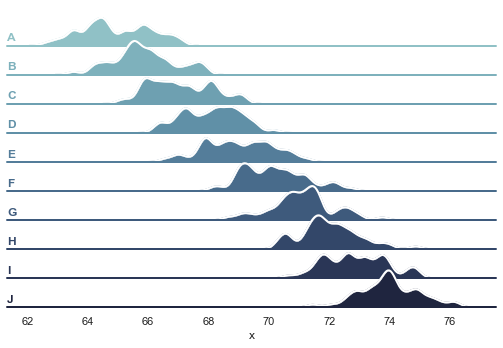

In [70]:

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

<Figure size 504x864 with 0 Axes>

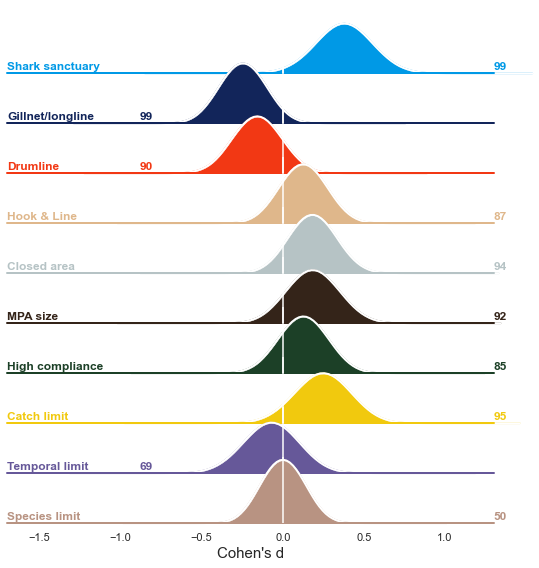

In [71]:
# Joy Division plot

fig = plt.figure(figsize=(7, 12))


# Initialize the FacetGrid object
g = sns.FacetGrid(dfx, row="variable", hue="variable", aspect=10, height=.8, palette=varpal)

# Draw the densities in a few steps
knl = 'epa'
g.map(sns.kdeplot, "Posterior", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2, kernel=knl)
g.map(sns.kdeplot, "Posterior", clip_on=False, color="w", lw=2, bw=.2, kernel=knl)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


lim = 1.7
yloc = 0.1
xos = 0.4

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, yloc, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.set_xlim(-lim,lim-xos)
    
# Define and use a simple function to label the plot in axes coordinates
def pd_label(x, color, label):
    ax = plt.gca()
    if np.median(x)<0:
        ax.text(0.3, yloc, str(int(np.round(100*(sum(x<0)/len(x)),0))), fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)
    else:
        ax.text(1, yloc, str(int(np.round(100*(sum(x>0)/len(x)),0))), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    ax.set_xlim(-lim,lim-xos)

g.map(label, "Posterior")
g.map(pd_label, "Posterior")


# Add line at zero
g.map(plt.axvline, x=0, color='w', linestyle='-')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("Cohen's d", fontsize=15)
plt.savefig('Figure_2b.pdf', bbox_inches='tight');

In [72]:
def PPplot(intercept,slope, covariate,label,bins=(90,80,70,60,50),ax=None, colx='black',ymax=4):
    x = np.linspace(min(covariate), max(covariate))
    for b in bins:
        # Plot shaded uncertainty regions
        lower = np.exp(np.percentile(intercept,50-b/2)+np.percentile(slope,50-b/2)*x)
        upper = np.exp(np.percentile(intercept,50+b/2)+np.percentile(slope,50+b/2)*x)
        ax.fill_between(x, lower, upper, where=upper>lower, facecolor=colx,alpha=0.1)
    y = np.exp(np.median(intercept)+np.median(slope)*x)
    ax.plot(x,y,colx,linewidth=3)
    ax.set_title(label)
    ax.set_ylim(0,ymax)

In [73]:
# Observed data for x-var plotting
pltdata = [(0,1),(0,1),(0,1),(-1,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)]

In [74]:
varlist

['Sanctuary',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Catch',
 'Temporal',
 'Species']

In [75]:
xlabs = [('Absent','Present'),('Absent','Present'),('Absent','Present'),('Absent','Present'),('Absent','Present'),('Min','Max'),('No','Yes'),('Absent','Present'),('Absent','Present'),('Absent','Present')]

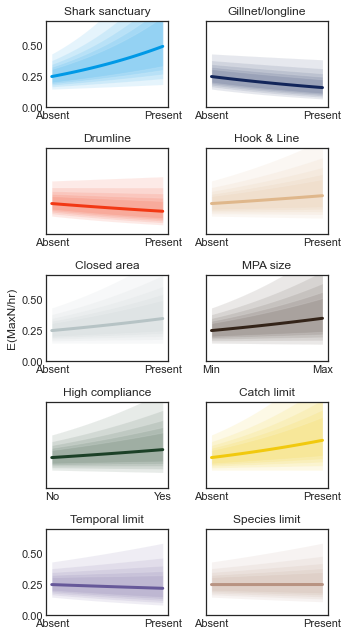

In [76]:
fig = plt.figure(figsize=(5, 9))
gs = mp.gridspec.GridSpec(5, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(5) for j in range(2)]).reshape(1,10)[0]

xadj = 5

grx = beta_global

for i in range(nvar):
    PPplot(grx,BTrez[varlist[i]],(0,1),varnames[i],colx=varpal[i],ax=ax_[i],ymax=.7)
    ax_[i].tick_params(axis=u'both', which=u'both',length=0)
    ax_[i].set_xticks((0,1))
    ax_[i].set_xticklabels(xlabs[i],rotation=0,ha='center')
    #if i==5:
        #ax_[i].set_ylabel('Expected MaxN change')

# Adjust labelling
[plt.setp(ax_[i].get_yticklabels(), visible=False) for i in (1,2,3,5,6,7,9)]


#plt.setp(ax_[7].get_xticklabels(), visible=False)

ax_[4].set_ylabel('E(MaxN/hr)')

plt.tight_layout()
plt.savefig('Figure_2a.pdf', bbox_inches='tight');

In [77]:
BTrez_SH_null.columns


Index(['Unnamed: 0', 'Global_rate', 'pi_t__0', 'pi_t__1', 'pi_t__2', 'pi_t__3',
       'η0_USA-Western Atlantic', 'η0_Bahamas', 'η0_Australia-Pacific',
       'η0_Australia IOT',
       ...
       'Regional_rate_Western Pacific', 'σ0_η', 'σ0_κ', 'σ0_υ_z',
       'Regional_zeros__0', 'Regional_zeros__1', 'Regional_zeros__2',
       'Regional_zeros__3', 'σ0_η_z', 'alpha'],
      dtype='object', length=156)

In [78]:
beta_Region.columns

Index(['Western Atlantic', 'Central Pacific', 'Indian Ocean',
       'Western Pacific'],
      dtype='object')

In [79]:
np.exp(np.quantile(beta_Region,(.5,.05,.95),axis=0))

array([[0.24263817, 0.29250859, 0.24228068, 0.23212652],
       [0.15218264, 0.17986621, 0.1525682 , 0.1419343 ],
       [0.38724911, 0.48783715, 0.37958504, 0.37663993]])

In [80]:
# Full + count model intercept weights
loo_f2 = (loo_f/(loo_c+loo_f))
loo_c2 = (loo_c/(loo_c+loo_f))
BG = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_f2+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values*loo_c2

In [81]:
# Regional rates
#"""
#"""
#"""
beta_Region_ex = np.exp(beta_Region)
beta_global_ex = np.exp(BG)
#"""


In [82]:
# Regional null rates
#"""
beta_Region_null = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
beta_Region_null.columns = [x[14:] for x in beta_Region_null.columns]
beta_global_null = BTrez_SH_null.Global_rate

#"""
#"""
beta_Region_null_ex = np.exp(BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)])
beta_Region_null_ex.columns = [x[14:] for x in beta_Region_null_ex.columns]
beta_global_null_ex = np.exp(BTrez_SH_null.Global_rate)
#"""


In [83]:
np.exp(np.quantile(beta_Region_null,(.5,.05,.95),axis=0))

array([[0.22896571, 0.59258157, 0.28741924, 0.17820909],
       [0.13752837, 0.35655603, 0.160935  , 0.08690092],
       [0.36720434, 0.97069469, 0.48492033, 0.35013199]])

In [84]:
# Difference from global intercept
Net_null_shark = beta_Region_null.sub(beta_global_null.squeeze(),axis=0).dropna()
Net_shark = beta_Region.sub(BG.squeeze(),axis=0).dropna()

In [85]:
Net_null_shark.columns.values

array(['Western Atlantic', 'Central Pacific', 'Indian Ocean',
       'Western Pacific'], dtype=object)

In [86]:
valx = Net_null_shark.columns.values
colx = ['turquoise','blue','xkcd:sienna','xkcd:burgundy']

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, lab

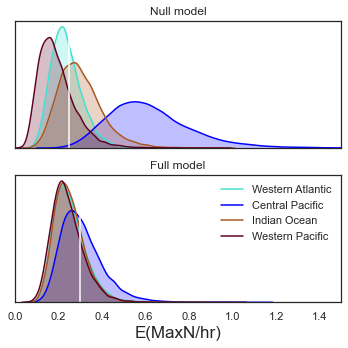

In [87]:
fig = plt.figure(figsize=(5,5))
gs = mp.gridspec.GridSpec(2, 1)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(2) for j in range(1)]).reshape(1,2)[0]

for i in range(len(valx)):
    sns.kdeplot(beta_Region_null_ex[valx[i]],shade=True,c=colx[i],ax=ax_[0],legend=False, gridsize=1000)
    sns.kdeplot(beta_Region_ex[valx[i]],shade=True,c=colx[i],ax=ax_[1], gridsize=1000)

ax_[0].set_title('Null model')
ax_[1].set_title('Full model') 
    
# Tidy plots
lim = 1.5
ax_[0].set_xlim(-0,lim)
ax_[0].axvline(np.median(beta_global_ex),linestyle="-",c="white")
ax_[1].set_xlim(-0,lim)
ax_[1].axvline(beta_global_null_ex.median(),linestyle="-",c="white")
ax_[1].set_xlabel('E(MaxN/hr)',fontsize=17)

plt.setp(ax_[0].get_yticklabels(), visible=False)
plt.setp(ax_[0].get_xticklabels(), visible=False)
plt.setp(ax_[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig('Figure_1c.pdf', bbox_inches='tight');

In [88]:
# Observed positive records
OCC_reef = np.array([(np.sum(xdata.MaxN_shark.values[xdata.reef_id.values==R])>0)*1 for R in Reef])
# Observed averages
mu_reef = np.array([np.mean(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
# Probability of a shark
p_set = np.array([sum((xdata.MaxN_shark.values[xdata.reef_id.values==R]>0)*1)/len(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
p_reef = np.array([np.sum(p_set[Ilr==i]>0)/len(p_set[Ilr==i]) for i in range(nlocs)])

In [89]:
len(np.array(RegionL)[Irl])

58

In [90]:
# Proportion of reefs without sharks
1-sum(p_set>0)/len(p_set)

0.19407008086253374

In [91]:
pd.DataFrame({'Location':LocationR, 'Region':np.array(RegionL)[Irl], 'Nreefs':[len(p_set[Ilr==i]) for i in range(nlocs)],'Mean_P(no_sharks)':p_reef}).to_csv('Mean_ReefAbsence.csv',index=False)

In [92]:
# Number of replicate sets per reef
nreps_r = np.array([len(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
np.median(nreps_r)

39.0

In [93]:
np.mean(p_set[Ilr==LocationR.index('Australia-Pacific')])

0.7219218896732815

In [94]:
np.mean(p_set[Ilr==LocationR.index('French Polynesia')])

0.7903015083591798

In [95]:
rnam = np.array([xdata.reef_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])

In [96]:
# Reef-scale lat/lon
SSlat = np.array([np.mean(xdata.set_latitude.values[xdata.reef_id.values==R]) for R in Reef])
SSlon = np.array([np.mean(xdata.set_longitude.values[xdata.reef_id.values==R]) for R in Reef])

In [97]:
mp.pyplot.style.use('seaborn-darkgrid')

In [98]:
# Symbols for each region type
regnam = np.array([xdata.region_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])
Reg,Irg = indexall(regnam)

rsym = np.array(['^','o','s','D'])[Irg]

In [100]:
"""
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()
m.drawparallels(np.arange(int(-30.1),int(30.1),15), labels=[1,0,1], linewidth=0.0)
m.drawmeridians(np.arange(int(0),int(360),50),labels=[1,0,1], linewidth=0.0)


# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
cmap = co.cm.gray_r
zz = np.array([cmap([p_set[i]]) for i in range(nreefs)])


# Plot points
[plt.scatter(x, y, c=z, edgecolor='#909090', linewidth=0.7, s=70, alpha=1, marker=m, zorder=5) for x,y,z,m in zip(xx,yy,zz,rsym)];


cax = fig.add_axes([0.966, 0.2, 0.02, 0.6])
norm = mp.colors.Normalize(vmin=min(mu_reef), vmax=max(mu_reef))
cb = mp.colorbar.ColorbarBase(cax, cmap, label='Proportion of sets with sharks')
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Proportion of sets with sharks', size=15)

fig.tight_layout()
plt.savefig('Figure_1a.pdf', bbox_inches='tight');
#"""

"\nfig = plt.figure(figsize=(15, 5))\n# Instantiate basemap\nm = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')\nm.drawcoastlines()\n#m.drawcountries()\nm.fillcontinents()\nm.drawparallels(np.arange(int(-30.1),int(30.1),15), labels=[1,0,1], linewidth=0.0)\nm.drawmeridians(np.arange(int(0),int(360),50),labels=[1,0,1], linewidth=0.0)\n\n\n# Convert longitude\nSSlon[SSlon<0] = SSlon[SSlon<0]+360\nxx,yy = m(SSlon,SSlat)\ncmap = co.cm.gray_r\nzz = np.array([cmap([p_set[i]]) for i in range(nreefs)])\n\n\n# Plot points\n[plt.scatter(x, y, c=z, edgecolor='#909090', linewidth=0.7, s=70, alpha=1, marker=m, zorder=5) for x,y,z,m in zip(xx,yy,zz,rsym)];\n\n\ncax = fig.add_axes([0.966, 0.2, 0.02, 0.6])\nnorm = mp.colors.Normalize(vmin=min(mu_reef), vmax=max(mu_reef))\ncb = mp.colorbar.ColorbarBase(cax, cmap, label='Proportion of sets with sharks')\ncb.ax.tick_params(labelsize=15)\ncb.set_label(label='Proportion of sets with sharks', size=15)\n\nfig.tight_layout()\nplt.

In [101]:
lox = np.array([xdata.location_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])

In [102]:
pd.DataFrame({'Location':lox,'Reef_ID':Reef, 'ReefName':rnam, 'Region':regnam, 'Lat':SSlat, 'Lon':SSlon}).to_csv('ReefCheck.csv',index=False)

In [103]:
xdata.columns

Index(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code', 'set_id',
       'set_code', 'set_date', 'set_latitude', 'set_longitude', 'maxn',
       'functional_group', 'depth', 'drop_time', 'haul_time', 'bait',
       'bait_oiled', 'current_flow_estimated', 'current_flow_instrumented',
       'visibility', 'field_of_view', 'substrate_relief_sd',
       'substrate_relief_mean', 'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones', 'unconsolidated',
       'zoanthids', 'video_length_watched', 'video_filename', 'vide

# National comparison



Re-do these scores using observed null model (nussiance parameters only) and the addition of each  new management option -; explain this rationale in the conservation score methods!

In [104]:
# National rates
#"""
beta_nation = np.exp(BTrez_SH_full[grep('η0_',BTrez_SH_full.columns.values)]*loo_f2+BTrez_SH_count[grep('η0_',BTrez_SH_count.columns.values)]*loo_c2)
beta_nation.columns = [x[3:] for x in beta_nation.columns]
Bnation = beta_nation.median(axis=0)
BNx = Bnation.sub(np.exp(beta_Region).median(axis=0).values[Ig],axis=0)
#"""



In [105]:
beta_nation.mean(axis=0)

USA-Western Atlantic              0.430542
Bahamas                           0.387180
Australia-Pacific                 0.446686
Australia IOT                     0.243423
Maldives                          0.455422
Malaysia                          0.130621
Solomon Islands                   0.384041
Indonesia                         0.157802
Palau                             0.562727
American Samoa                    0.247169
New Caledonia                     0.690634
Belize                            0.268863
Jamaica                           0.241519
Trinidad and Tobago               0.393160
Vanuatu                           0.329458
British West Indies               0.271873
Fiji                              0.339991
Colombia                          0.132507
Australia-Indian Ocean            0.282359
South Africa                      0.313897
Mozambique                        0.239363
Niue                              0.543154
Japan                             0.155749
Seychelles 

In [106]:
# National rates
#"""
beta_nation_null = np.exp(BTrez_SH_null[grep('η0_',BTrez_SH_null.columns.values)])
beta_nation_null.columns = [x[3:] for x in beta_nation_null.columns]
Bnation_null = beta_nation_null.median(axis=0)
BNx_null = Bnation_null.sub(np.exp(beta_Region_null).median(axis=0).values[Ig],axis=0)
#"""


In [107]:
Bnation_null

USA-Western Atlantic              0.365070
Bahamas                           0.592238
Australia-Pacific                 1.330117
Australia IOT                     0.653414
Maldives                          0.469350
Malaysia                          0.135114
Solomon Islands                   0.542096
Indonesia                         0.129042
Palau                             0.796292
American Samoa                    0.397397
New Caledonia                     1.667867
Belize                            0.277084
Jamaica                           0.181637
Trinidad and Tobago               0.422641
Vanuatu                           0.351397
British West Indies               0.237086
Fiji                              0.340953
Colombia                          0.064008
Australia-Indian Ocean            0.836141
South Africa                      0.550599
Mozambique                        0.312680
Niue                              0.977926
Japan                             0.095951
Seychelles 

In [108]:
# Regional colors
colsx = np.array(colx)[Ig]

In [109]:
BTrez_SH_null.head()

,Unnamed: 0,Global_rate,pi_t__0,pi_t__1,pi_t__2,pi_t__3,η0_USA-Western Atlantic,η0_Bahamas,η0_Australia-Pacific,η0_Australia IOT,...,Regional_rate_Western Pacific,σ0_η,σ0_κ,σ0_υ_z,Regional_zeros__0,Regional_zeros__1,Regional_zeros__2,Regional_zeros__3,σ0_η_z,alpha
0,0,-1.583659,0.088167,0.621406,-0.180973,0.111352,-1.476539,-0.232598,0.338663,-0.253124,...,-1.410273,1.000561,1.072866,1.739983,8.527868,10.476610,6.465139,7.655935,7.668780,6.528335
1,1,-0.484740,-0.620667,0.108466,-0.680332,-0.217182,-1.240408,-0.340204,-0.066751,0.036098,...,-0.867132,1.036508,1.188762,1.475393,6.178200,7.440682,5.237715,6.249266,8.989780,7.465940
2,2,-0.906508,-0.639613,0.047206,-0.723437,-0.274638,-0.697273,-0.408274,-0.083422,0.016188,...,-1.132864,1.028088,1.194473,0.355435,7.015247,7.457838,6.977492,7.302841,7.864036,7.268930
3,3,-0.591007,-0.656047,0.019008,-0.629347,-0.905808,-0.766692,-0.754586,0.956137,-0.078553,...,-1.789338,1.052344,1.152056,1.911426,6.564672,5.572458,7.914495,6.033966,8.089471,6.245186
4,4,-0.624174,-1.398446,-0.597614,-0.967315,-1.148977,-1.451582,-0.328556,0.345725,-0.522018,...,-1.551866,1.102858,1.042604,0.227840,7.710936,7.857853,7.562839,7.767864,6.987470,6.589936


In [110]:
colnames = BTrez_SH_null.columns.values

In [111]:
# Regional expected value
REx = pd.DataFrame(BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])]])
REx.columns = [x[14:] for x in REx.columns]
RMedian = REx.median()

# National expected value
ex_val = BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])]]
ex_val.columns = [x[3:] for x in ex_val.columns.values]
ex_val = ex_val[ex_val.mean().sort_values().index.values]
Elocation = ex_val.columns.values

In [112]:
ex_val

,Philippines,Colombia,Sri Lanka,Dutch Antilles Leeward,Japan,Guam,Tanzania,Indonesia,Malaysia,Brazil,...,Kiribati,Tonga,Palau,Australia-Indian Ocean,Niue,New Zealand,Federated States of Micronesia,French Polynesia,Australia-Pacific,New Caledonia
0,-1.711950,-2.458609,-3.117213,-2.527233,-3.171107,-2.350125,-3.126986,-2.542137,-1.502528,-1.573325,...,-0.398312,-0.013291,-0.084263,-0.225502,-0.111619,-0.342683,0.680194,0.625912,0.338663,0.418428
1,-2.898596,-3.727810,-5.018474,-2.123142,-1.892981,-2.082203,-2.890205,-1.787557,-0.483410,-2.743977,...,-0.324553,-0.795069,0.430134,-0.017876,0.255896,0.598501,0.572607,0.392175,-0.066751,0.195347
2,-2.671257,-3.636824,-4.966150,-2.032977,-2.230057,-2.379010,-2.541541,-2.139323,-0.926604,-2.685741,...,-0.173285,-0.998080,0.126679,0.209775,0.354252,-0.372547,0.195259,0.540171,-0.083422,-0.512897
3,-2.887443,-3.438088,-3.666891,-1.810271,-2.801388,-2.454020,-1.494913,-1.884802,-1.026744,-1.787843,...,0.470589,-0.743064,-0.167636,0.142522,-0.091331,-0.164663,0.841364,0.478590,0.956137,0.183923
4,-2.454554,-2.600110,-3.770293,-2.308293,-1.684953,-3.068578,-3.435531,-1.645076,-2.068453,-1.480364,...,0.235682,-0.862293,0.707545,-0.201206,-0.183543,1.045682,0.424708,0.291959,0.345725,0.568629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-2.147959,-2.925740,-2.821911,-2.265894,-2.670994,-1.950321,-1.504697,-2.269890,-1.351597,-2.235395,...,-0.770705,-0.033682,-0.493182,-0.176541,-0.167338,-0.218709,0.240831,0.089085,0.028424,0.847234
19996,-3.460901,-1.847612,-2.677737,-1.940592,-2.256891,-2.041478,-2.600440,-1.940075,-2.030621,-2.213300,...,0.051639,-0.395774,-1.298142,-0.231073,0.163513,-0.100813,-0.624007,-0.165309,-0.059686,1.025770
19997,-2.234244,-4.011305,-2.601746,-2.371459,-2.104897,-2.699987,-2.630281,-2.706301,-1.909722,-1.859313,...,-1.046838,-1.286794,0.201778,-0.280788,-0.716188,-0.737278,0.075112,0.378998,0.430705,-0.386284
19998,-3.224123,-2.395646,-2.802945,-2.186005,-2.294638,-3.024493,-2.430645,-2.538455,-2.569864,-2.542767,...,-1.013927,-0.222647,-1.175015,-0.324791,0.022369,-0.786286,-0.166220,-0.225391,0.146503,1.094154


In [113]:
RMedian

Western Atlantic   -1.474183
Central Pacific    -0.523267
Indian Ocean       -1.246813
Western Pacific    -1.724798
dtype: float64

In [114]:
# National presence
p_presence = invlogit(BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('η0z',colnames)])]])
p_presence.columns = [x[4:] for x in p_presence.columns.values]
p_presence = p_presence[p_presence.mean().sort_values().index.values]
Plocation = p_presence.columns.values

In [115]:
p_presence['South Africa'].median()


0.46061660513922753

In [116]:
# Key to match null model estimates to observed nation indexing
lindx = np.array([LocationR.index(x) for x in Elocation])
lindx

array([29, 17, 40, 54, 22, 50, 41,  7,  5, 35, 34, 28, 55, 56, 24, 53, 12,
       52, 47, 57, 49, 38, 48, 45, 26, 46, 15, 11, 20, 37, 42, 16, 31, 14,
        0, 32, 33,  9, 13, 39,  4,  6, 19, 23,  1,  3, 36, 51, 25, 43,  8,
       18, 21, 44, 27, 30,  2, 10])

In [117]:
# Regional index for new location order
zkey = pd.DataFrame({'Location':Elocation,'Region':np.array(Region)[Ig][lindx]})
zkey = zkey.set_index('Location')

In [118]:
# Get proportion of reefs with gillnets and longlines - use lindx to match order with those in results
zkey['propgill'] = np.array([sum(GILL[Ilr==lindx[i]])/len(GILL[Ilr==lindx[i]]) for i in range(nlocs)])
# Get proportion of reefs without closures
zkey['propclo'] = 1-np.array([sum(CLO[Ilr==lindx[i]])/len(CLO[Ilr==lindx[i]]) for i in range(nlocs)])
# Get proportion of reefs without shark sanctuary
zkey['propban'] = 1-SSA[lindx]
# Get proportion of reefs without Catch limits
zkey['propcat'] = 1-np.array([sum(BAG[Ilr==lindx[i]])/len(BAG[Ilr==lindx[i]]) for i in range(nlocs)])
# Get expected value from null model
zkey['ex_val'] = ex_val.median(axis=0)

In [238]:
# Expected value per location
exobs = np.exp(zkey.ex_val)

In [239]:
# Get gillnet effect sizes per location
gilman = zkey.ex_val+zkey.propgill*(np.median(beta_Gill)*-1)

# Get gillnet MaxN effect sizes per location
gilman_ex = np.exp(zkey.ex_val+zkey.propgill*(np.median(beta_Gill)*-1))

In [288]:
np.median(beta_Gill)

-0.44604883029761655

In [240]:
# Get large closure effect sizes per location
cloman = zkey.ex_val+zkey.propclo*np.median(beta_clo)+zkey.propclo*np.median(beta_MPAsize)

# Get large closure MaxN effect sizes per location
cloman_ex = np.exp(zkey.ex_val+zkey.propclo*np.median(beta_clo)+zkey.propclo*np.median(beta_MPAsize))

In [241]:
# Get average closure effect sizes per location
cloman2 = zkey.ex_val+zkey.propclo*np.median(beta_clo)

In [242]:
# Get shark sanctuary effect per location
banman = zkey.ex_val+zkey.propban*np.median(beta_Sanctuary)

# Get shark sanctuary MaxN effect per location
banman_ex = np.exp(zkey.ex_val+zkey.propban*np.median(beta_Sanctuary))

In [243]:
# Get Catch limit effect per location
catman = zkey.ex_val+zkey.propcat*np.median(beta_Catch)

catman_ex = np.exp(zkey.ex_val+zkey.propcat*np.median(beta_Catch))

(1.0, 1.0)

In [283]:
np.exp(np.median(beta_Catch))-1, 1-np.exp(np.median(beta_Gill))

(0.5616943058998285, 0.3598474875392579)

# Conservation potential

In [131]:
# Proportion of regional-scale posterior less than national expexcted values
Depletion = pd.DataFrame([sum(zkey.ex_val[c]>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T
Depletion.columns = Elocation
Depletion = Depletion[Depletion.median().sort_values().index.values]
Dlocs = Depletion.columns

## Number of sharks not seen
Number seen per nation/conservation status

In [138]:
xdata.columns

Index(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code', 'set_id',
       'set_code', 'set_date', 'set_latitude', 'set_longitude', 'maxn',
       'functional_group', 'depth', 'drop_time', 'haul_time', 'bait',
       'bait_oiled', 'current_flow_estimated', 'current_flow_instrumented',
       'visibility', 'field_of_view', 'substrate_relief_sd',
       'substrate_relief_mean', 'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones', 'unconsolidated',
       'zoanthids', 'video_length_watched', 'video_filename', 'vide

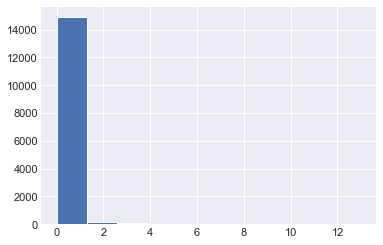

In [139]:
plt.hist(xdata.maxn);

In [140]:
# Total sharks seen
xdata.groupby(['location_name']).sum().MaxN_shark.sum()

12419

In [141]:
Depletion2 = pd.DataFrame([sum(zkey.ex_val[c]>REx[zkey.Region[c]])/len(REx[zkey.Region[c]]) for c in Elocation]).T
Depletion2.columns = Elocation

In [142]:
tmp = pd.DataFrame(Depletion2.T).join(pd.DataFrame(xdata.groupby(['location_name']).sum().MaxN_shark))
tmp = tmp.join(xdata['location_name'].value_counts())
tmp.columns = ['ConSco','MaxN','NBRUVS']
tmp.ConSco[tmp.ConSco<0.01] = 0.01

<ipython-input-142-2108d3580552>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.ConSco[tmp.ConSco<0.01] = 0.01


In [143]:
# MaxN per BRUVS for top 10% of Conservation Scores
ExMaxNBRuv = (tmp.MaxN/tmp.NBRUVS)[tmp.ConSco>0.90].median()
ExMaxNBRuv

1.1546391752577319

In [144]:
tmp['Expected_MaxN'] = (ExMaxNBRuv*tmp.NBRUVS).astype(int)
tmp['Missing'] = [max(0,x-o) for x,o in zip(tmp.Expected_MaxN,tmp.MaxN)]

In [145]:
(tmp.MaxN/tmp.NBRUVS)[tmp.ConSco>0.99]

Solomon Islands                   1.390476
Bahamas                           0.917539
Australia IOT                     1.389755
Columbia SF                       1.526316
Australia-Indian Ocean            1.001555
Federated States of Micronesia    2.306878
French Polynesia                  1.956685
Australia-Pacific                 1.732639
New Caledonia                     2.659864
dtype: float64

In [146]:
tmp

,ConSco,MaxN,NBRUVS,Expected_MaxN,Missing
Philippines,0.01000,108,307,354,246
Colombia,0.01000,9,189,218,209
Sri Lanka,0.01000,6,153,176,170
Dutch Antilles Leeward,0.01000,73,440,508,435
Japan,0.07500,8,105,121,113
Guam,0.01000,27,182,210,183
Tanzania,0.01000,7,93,107,100
Indonesia,0.22650,195,975,1125,930
Malaysia,0.25960,74,479,553,479
Brazil,0.05315,32,192,221,189


In [147]:
tmp.MaxN.sum(),tmp.Missing.sum(),tmp.Expected_MaxN.sum()

(12419, 7937, 17483)

In [148]:
tmp.MaxN.sum()

12419

In [206]:
plt.scatter(gillma)

Dutch Antilles Windward           0.000889
Qatar                             0.002571
Kenya                             0.003120
Dominican Republic                0.003188
Vietnam                           0.003528
Jamaica                           0.003656
French West Indies                0.004311
India                             0.005734
Taiwan                            0.267302
Bermuda                           0.115255
South Africa                      0.460617
Trinidad and Tobago               0.488649
Australia IOT                     0.783925
Mozambique                        0.776953
Sri Lanka                         0.982856
Mayotte                           0.977851
Papua New Guinea                  0.843543
Colombia                          0.996451
Tanzania                          0.995346
Philippines                       0.939049
Madagascar                        0.991414
Japan                             0.997601
New Caledonia                     0.922359
Vanuatu    

In [227]:
np.exp(zkey.ex_val['South Africa']+np.median(beta_Sanctuary))/np.exp(zkey.ex_val['South Africa'])

1.9821356467041749

In [291]:
tmp = exobs
tmp2 = cloman_ex-tmp

In [293]:
cloman_ex/tmp

Location
Philippines                       1.647653
Colombia                          1.946051
Sri Lanka                         1.558725
Dutch Antilles Leeward            1.724172
Japan                             1.946051
Guam                              1.000000
Tanzania                          1.946051
Indonesia                         1.861561
Malaysia                          1.181105
Brazil                            1.462955
Barbados                          1.946051
Vietnam                           1.946051
Cuba                              1.305154
Bermuda                           1.946051
Taiwan                            1.647653
French West Indies                1.647653
Jamaica                           1.647653
Dominican Republic                1.000000
Dutch Antilles Windward           1.181105
Puerto Rico                       1.000000
Saudi Arabia-Red Sea              1.000000
Mayotte                           1.946051
Madagascar                        1.608936
In

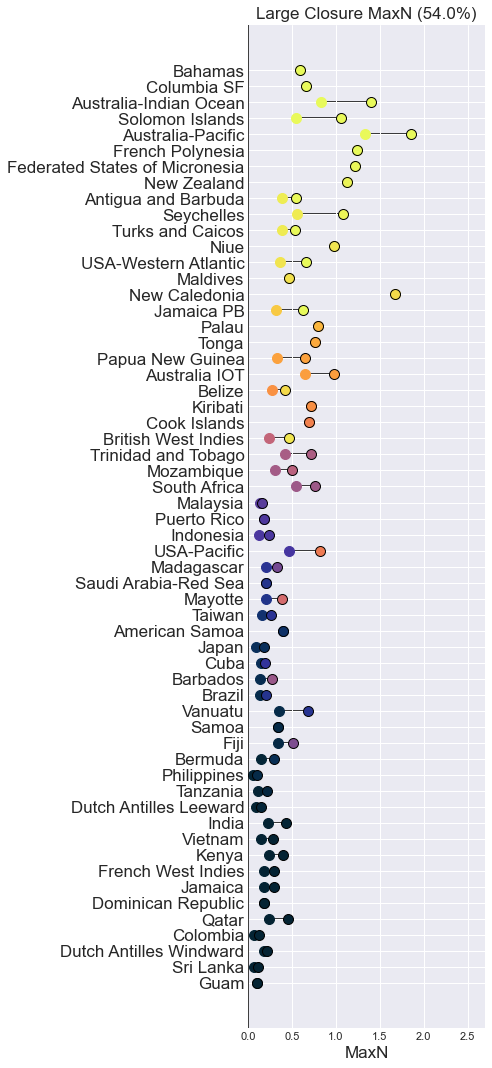

In [302]:
# Large MPA absolute effect
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)

tmp = exobs
tmp2 = cloman_ex

[ax.plot((tmp[Dlocs[i]],tmp2[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(tmp[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(tmp2[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0., color='black', linestyle='-')
#plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
#plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('MaxN',fontsize=17)
ax.set_xlim(0,2.7)
ax.set_title('Large Closure MaxN ('+str(round(np.median((tmp2/tmp))-1,2)*100)+'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_EMaxN_lgClosure.jpg');

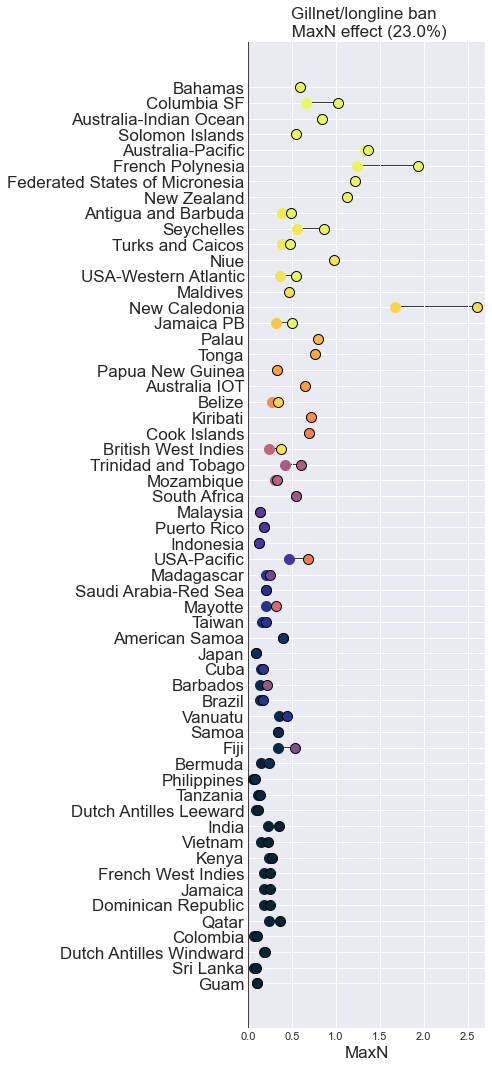

In [303]:
# Gillnet ban absolute effect
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)

tmp = exobs
tmp2 = gilman_ex

[ax.plot((tmp[Dlocs[i]],tmp2[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(tmp[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(tmp2[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0., color='black', linestyle='-')
#plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
#plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('MaxN',fontsize=17)
ax.set_xlim(0,2.7)

ax.set_title('Gillnet/longline ban \n MaxN effect ('+str(round(np.median((tmp2/tmp))-1,2)*100)+'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_EMaxN_gillLong.jpg');

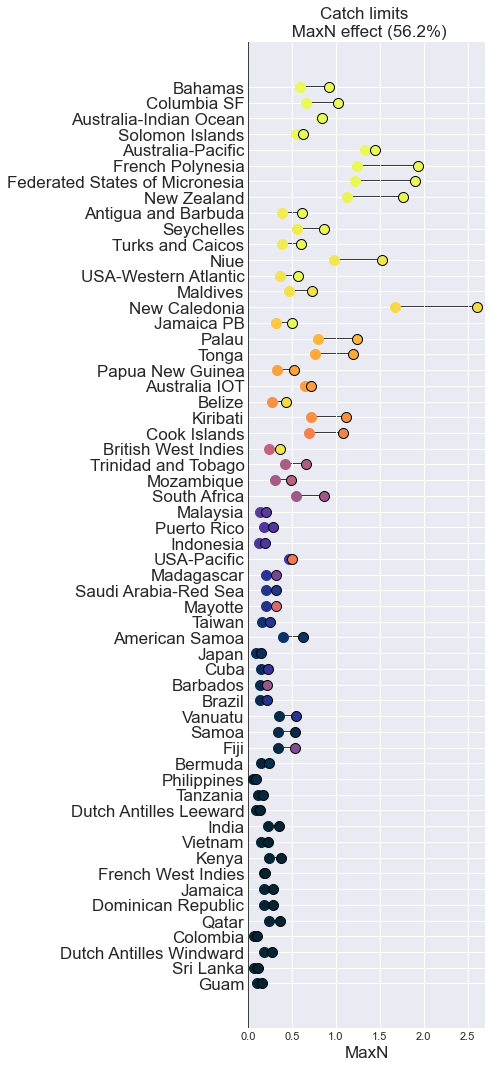

In [309]:
# Catch limit absolute effect
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)

tmp = exobs
tmp2 = catman_ex

[ax.plot((tmp[Dlocs[i]],tmp2[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(tmp[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(tmp2[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0., color='black', linestyle='-')
#plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
#plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('MaxN',fontsize=17)
ax.set_xlim(0,2.7)

ax.set_title('Catch limits \n MaxN effect ('+str(round(np.median((tmp2/tmp))-1,3)*100)+'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_EMaxN_catch.jpg');

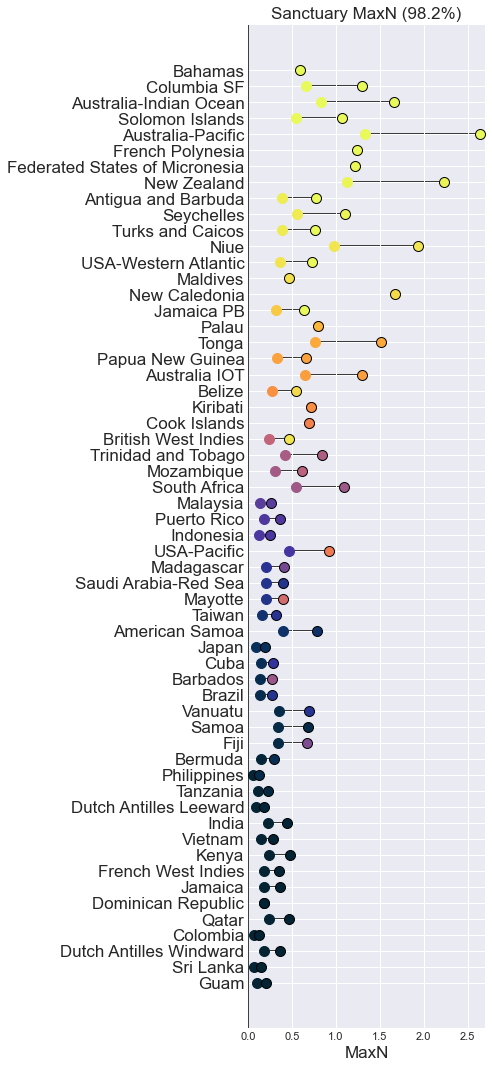

In [307]:
# Sanctuary absolute effect
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)

tmp = exobs
tmp2 = banman_ex

[ax.plot((tmp[Dlocs[i]],tmp2[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(tmp[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(tmp2[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0., color='black', linestyle='-')
#plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
#plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('MaxN',fontsize=17)
ax.set_xlim(0,2.7)

ax.set_title('Sanctuary MaxN ('+str(round(np.median((tmp2/tmp))-1,3)*100)+'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_EMaxN_sanctuary.jpg');

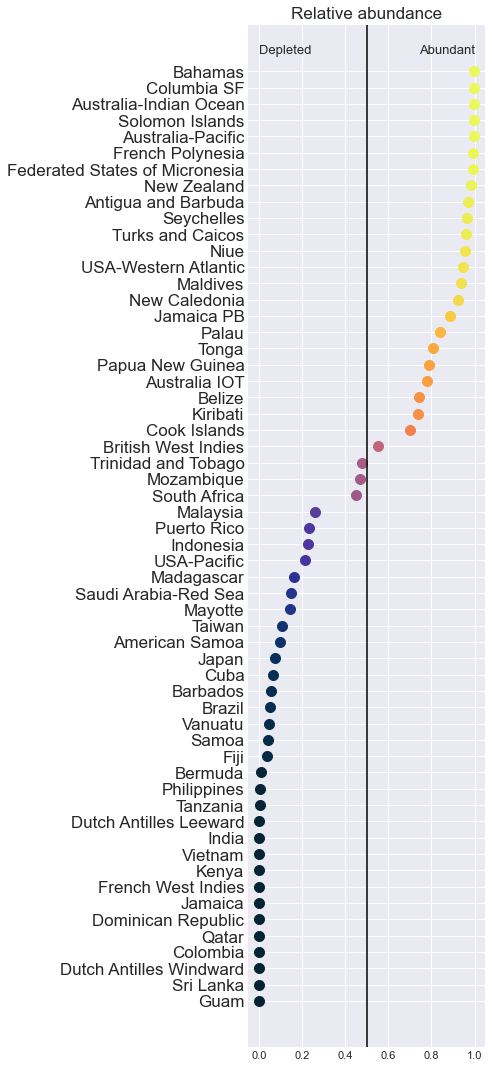

In [267]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


#[ax.plot((Depletion[Dlocs[i]],Depletion_gill[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
#[ax.scatter(Depletion_gill[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Relative abundance',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3x.pdf');

## Gillnet/longline potential

In [151]:
# National value scaled to region plus gillent potential
Depletion_gill = pd.DataFrame([sum(np.median(gilman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T
Depletion_gill.columns = Elocation
Depletion_gill = Depletion_gill[Dlocs.values]

In [152]:
imp_gill = Depletion_gill-Depletion
per_imp_gill = np.mean(imp_gill[imp_gill>0],axis=1)
per_imp_gill

0    0.086458
dtype: float64

In [153]:
np.mean(imp_gill,axis=1)

0    0.055154
dtype: float64

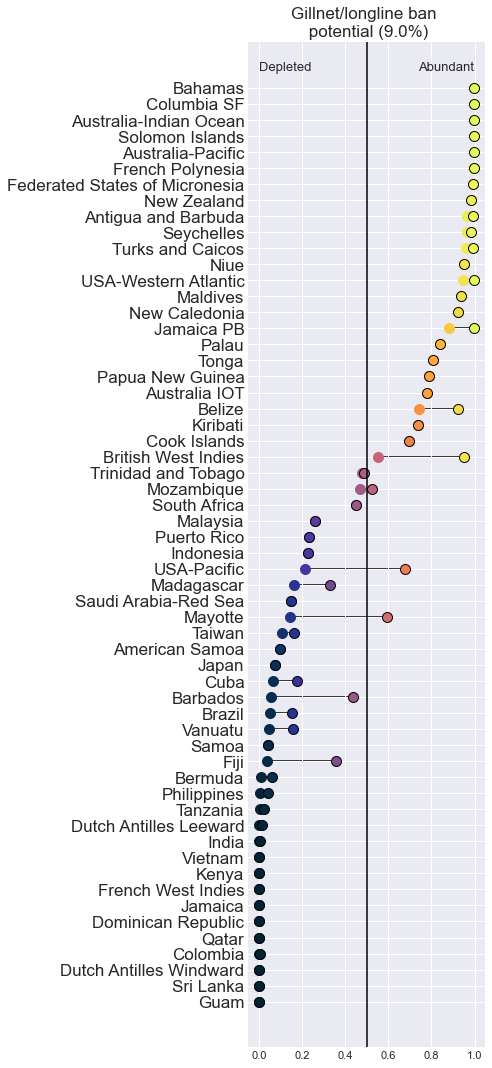

In [154]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_gill[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_gill[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Gillnet/longline ban \n potential ('+ str(np.round(per_imp_gill[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3b.pdf');

In [155]:
# National value scaled to region plus closure potential
Depletion_clo2 = pd.DataFrame([sum(np.median(cloman2[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T

Depletion_clo2.columns = Elocation
Depletion_clo2 = Depletion_clo2[Dlocs.values]

In [156]:
imp_clo2 = Depletion_clo2-Depletion
per_imp_clo2 = np.mean(imp_clo2[imp_clo2>0],axis=1)
per_imp_clo2

0    0.081245
dtype: float64

## Big closure potential

In [157]:
# National value scaled to region plus closure potential
Depletion_clo = pd.DataFrame([sum(np.median(cloman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T

Depletion_clo.columns = Elocation
Depletion_clo = Depletion_clo[Dlocs.values]

In [158]:
imp_clo = Depletion_clo-Depletion
per_imp_clo = np.mean(imp_clo[imp_clo>0],axis=1)
per_imp_clo

0    0.37394
dtype: float64

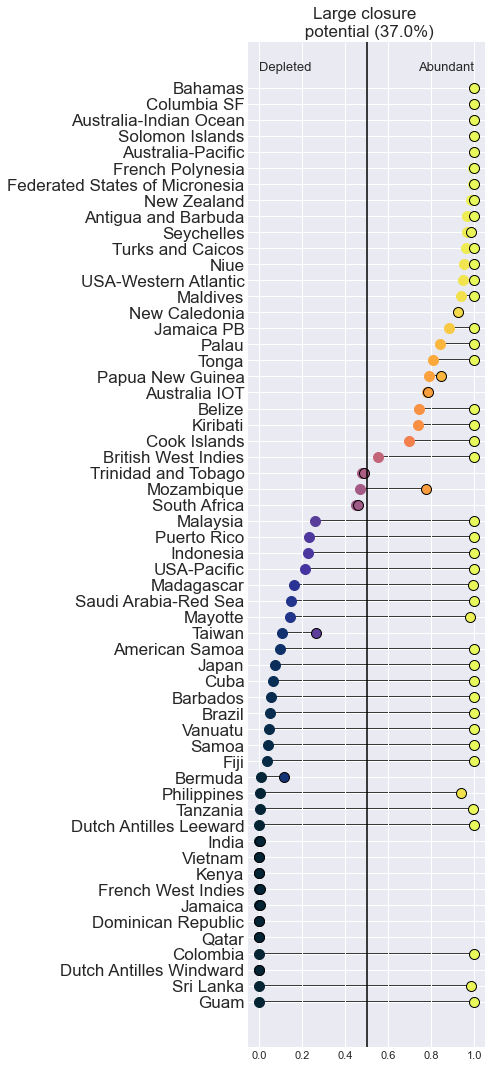

In [159]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_clo[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_clo[Dlocs[i]],i,c=co.cm.thermal(Depletion_clo[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Large closure \n potential ('+ str(np.round(per_imp_clo[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3c.pdf');

## Catch limit potential

In [160]:
# National value scaled to region plus closure potential
Depletion_cat = pd.DataFrame([sum(np.median(catman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Location]).T

Depletion_cat.columns = Location
Depletion_cat = Depletion_cat[Dlocs.values]

In [161]:
imp_cat = Depletion_cat-Depletion
per_imp_cat = np.mean(imp_cat[imp_cat>0],axis=1)
per_imp_cat

0    0.145095
dtype: float64

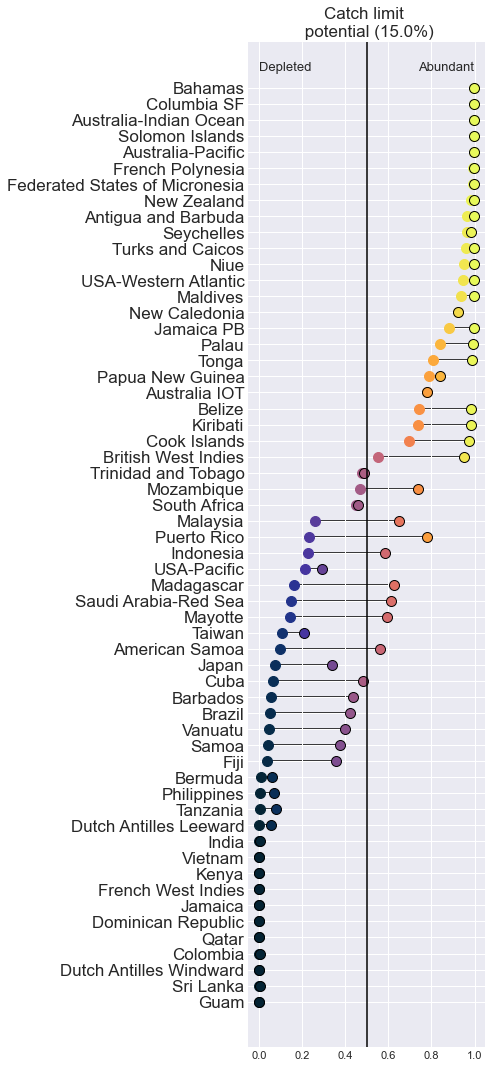

In [162]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_cat[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_cat[Dlocs[i]],i,c=co.cm.thermal(Depletion_cat[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Catch limit \n potential ('+ str(np.round(per_imp_cat[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3d.pdf');

## Shark Sanctuary potential

In [163]:
# National value scaled to region plus closure potential
Depletion_ban = pd.DataFrame([sum(np.median(banman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Location]).T

Depletion_ban.columns = Location
Depletion_ban = Depletion_ban[Dlocs.values]

In [164]:
Depletion_ban['South Africa']

0    0.460617
Name: South Africa, dtype: float64

In [165]:
np.median(p_presence['South Africa'])

0.46061660513922753

In [166]:
Depletion['South Africa']

0    0.450829
Name: South Africa, dtype: float64

In [167]:
imp_ban = Depletion_ban-Depletion
per_imp_ban = np.mean(imp_ban[imp_ban>0],axis=1)
per_imp_ban

0    0.37394
dtype: float64

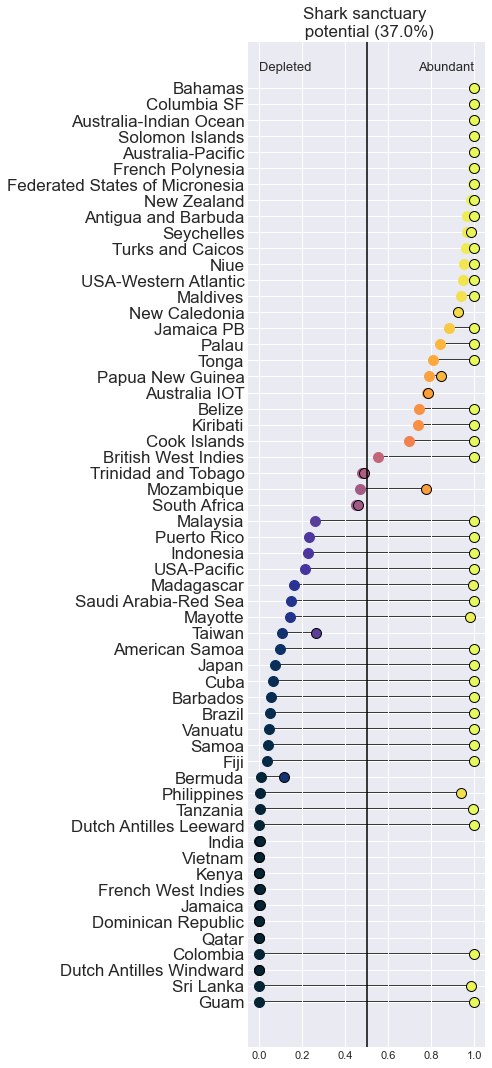

In [168]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_ban[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_ban[Dlocs[i]],i,c=co.cm.thermal(Depletion_ban[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Shark sanctuary \n potential ('+ str(np.round(per_imp_ban[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3e.pdf');

In [169]:
Depletion

,Guam,Sri Lanka,Dutch Antilles Windward,Colombia,Qatar,Dominican Republic,Jamaica,French West Indies,Kenya,Vietnam,...,Seychelles,Antigua and Barbuda,New Zealand,Federated States of Micronesia,French Polynesia,Australia-Pacific,Solomon Islands,Australia-Indian Ocean,Columbia SF,Bahamas
0,0.0,0.000098,0.00021,0.000249,0.000703,0.000711,0.000805,0.000881,0.000926,0.001107,...,0.963727,0.96735,0.982967,0.991015,0.991887,0.995624,0.996012,0.998872,0.99904,0.999098


In [170]:
Depletion_ban

,Guam,Sri Lanka,Dutch Antilles Windward,Colombia,Qatar,Dominican Republic,Jamaica,French West Indies,Kenya,Vietnam,...,Seychelles,Antigua and Barbuda,New Zealand,Federated States of Micronesia,French Polynesia,Australia-Pacific,Solomon Islands,Australia-Indian Ocean,Columbia SF,Bahamas
0,0.999871,0.982856,0.000889,0.996451,0.002571,0.003188,0.003656,0.004311,0.00312,0.003528,...,0.982443,0.999638,0.999763,0.999965,0.999987,0.999974,0.999661,0.999172,0.99944,0.999898


In [171]:
imp_gill

,Guam,Sri Lanka,Dutch Antilles Windward,Colombia,Qatar,Dominican Republic,Jamaica,French West Indies,Kenya,Vietnam,...,Seychelles,Antigua and Barbuda,New Zealand,Federated States of Micronesia,French Polynesia,Australia-Pacific,Solomon Islands,Australia-Indian Ocean,Columbia SF,Bahamas
0,0.0,0.002113,0.000036,0.005281,0.001295,0.001334,0.001526,0.001771,0.000373,0.00141,...,0.018568,0.02784,0.0,0.0,0.00805,0.0012,0.0,0.0001,0.0004,0.0


In [172]:
# Conservation potential per management technique
ConPoMGMT = imp_gill.append(imp_clo, ignore_index=True)
ConPoMGMT = ConPoMGMT.append(imp_cat, ignore_index=True)
ConPoMGMT = ConPoMGMT.append(imp_ban, ignore_index=True)
ConPoMGMT.index = ['Gillnet/longline ban','Large closure', 'Catch limit', 'Sanctuary']
ConPoMGMT.T.to_csv('ConPoMGMT.csv')

In [173]:
ConPoMGMT.columns

Index(['Guam', 'Sri Lanka', 'Dutch Antilles Windward', 'Colombia', 'Qatar',
       'Dominican Republic', 'Jamaica', 'French West Indies', 'Kenya',
       'Vietnam', 'India', 'Dutch Antilles Leeward', 'Tanzania', 'Philippines',
       'Bermuda', 'Fiji', 'Samoa', 'Vanuatu', 'Brazil', 'Barbados', 'Cuba',
       'Japan', 'American Samoa', 'Taiwan', 'Mayotte', 'Saudi Arabia-Red Sea',
       'Madagascar', 'USA-Pacific', 'Indonesia', 'Puerto Rico', 'Malaysia',
       'South Africa', 'Mozambique', 'Trinidad and Tobago',
       'British West Indies', 'Cook Islands', 'Kiribati', 'Belize',
       'Australia IOT', 'Papua New Guinea', 'Tonga', 'Palau', 'Jamaica PB',
       'New Caledonia', 'Maldives', 'USA-Western Atlantic', 'Niue',
       'Turks and Caicos', 'Seychelles', 'Antigua and Barbuda', 'New Zealand',
       'Federated States of Micronesia', 'French Polynesia',
       'Australia-Pacific', 'Solomon Islands', 'Australia-Indian Ocean',
       'Columbia SF', 'Bahamas'],
      dtype='object')

In [174]:
# Total conservation potential - max of other measures or shark Sanctuary
con_potential = pd.DataFrame(np.array([max(g+c+b,s) for g,c,b,s in zip(imp_gill.iloc[0,].values,imp_clo.iloc[0,].values,imp_cat.iloc[0,].values,imp_ban.iloc[0,].values)])).T
con_potential.columns = imp_clo.columns
con_potential.T

,0
Guam,0.999871
Sri Lanka,0.991063
Dutch Antilles Windward,0.001170
Colombia,1.006764
Qatar,0.004457
Dominican Republic,0.005560
Jamaica,0.006381
French West Indies,0.005698
Kenya,0.004139
Vietnam,0.005239


In [175]:
SSlon = Lon
SSlat = Lat

In [176]:
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

"""
for i in range(nlocs):
    if Location[i]=='Belize':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif Location[i]=='Dutch Antilles Leeward':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass
"""
    
"""
for i in range(nlocs):
    if con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass



#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_3a.pdf', bbox_inches='tight');


NameError: name 'bm' is not defined

<Figure size 1080x360 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

"""
for i in range(nlocs):
    if Location[i]=='Belize':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif Location[i]=='Dutch Antilles Leeward':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass
"""
    
    
for i in range(nlocs):
    if con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass



#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_3ax.pdf', bbox_inches='tight');


In [ ]:
plt.hist(Depletion);

In [ ]:
tmp = con_potential.T
tmp.columns = ['ConPo']
ConX = tmp.sort_values('ConPo', ascending=False).join(Depletion.T)
ConX.to_csv('ConPo.csv')

In [ ]:
fig = plt.figure(figsize=(30, 20))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

for i in range(nlocs):
    plt.text(xx[i]+200000, yy[i], Location[i])




#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_all_nations.pdf', bbox_inches='tight');
